# NYC Subway Delay Prediction (MTA Open Data)

### Goal
Build a predictive model for **Additional Platform Time (APT)** — the estimated extra time (vs schedule) riders spend waiting on the platform.

### Why this is a good "delay" proxy
APT is directly tied to customer experience: it’s literally the extra waiting time beyond what’s scheduled.

### Data Sources
- **MTA Subway Customer Journey-Focused Metrics (Beginning 2025)** (includes APT, ATT, AJT, CJTP)
- **MTA Subway Delay-Causing Incidents (Beginning 2020)** (counts by line/category/day-type)


In [ ]:
# All of the imports that we need
!pip -q install holidays

import os
import re
import math
import json
import time
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

import holidays

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


## 1) Download subway data

These are Socrata datasets, but the easiest approach in a notebook is:
- download the full CSV once
- cache it under `data/`
- read with pandas


In [ ]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

def download_csv(url: str, out_path: str, force: bool = False) -> str:
    """
    Download a CSV once and cache it locally.
    If the file exists and force=False, we re-use it.

    This keeps the notebook fast + repeatable.
    """
    if os.path.exists(out_path) and not force:
        print(f"Using cached file: {out_path}")
        return out_path

    print(f"⬇️ Downloading: {url}")
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()

    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

    print(f"Saved to: {out_path} ({os.path.getsize(out_path)/1e6:.2f} MB)")
    return out_path


In [ ]:
# Official download links from data.ny.gov catalogs
CJ_CSV_URL = "https://data.ny.gov/api/views/s4u6-t435/rows.csv?accessType=DOWNLOAD"   # Customer Journey metrics (Beginning 2025)
INCIDENTS_CSV_URL = "https://data.ny.gov/api/views/g937-7k7c/rows.csv?accessType=DOWNLOAD"  # Delay-causing incidents (Beginning 2020)

cj_path = download_csv(CJ_CSV_URL, os.path.join(DATA_DIR, "mta_customer_journey_metrics.csv"))
inc_path = download_csv(INCIDENTS_CSV_URL, os.path.join(DATA_DIR, "mta_delay_incidents.csv"))

cj_raw = pd.read_csv(cj_path)
inc_raw = pd.read_csv(inc_path)

print("Customer Journey rows:", len(cj_raw), "cols:", cj_raw.shape[1])
print("Incidents rows:", len(inc_raw), "cols:", inc_raw.shape[1])

cj_raw.head()


Using cached file: data/mta_customer_journey_metrics.csv
Using cached file: data/mta_delay_incidents.csv
Customer Journey rows: 528 cols: 12
Incidents rows: 22127 cols: 6


,month,division,line,period,num_passengers,additional platform time,additional train time,total_apt,total_att,over_five_mins,over_five_mins_perc,customer journey time performance
0,2025-01-01,A DIVISION,1,offpeak,6.180143e+06,0.741047,0.532418,4.579779e+06,3.290418e+06,671979.372650,0.108732,0.891268
1,2025-01-01,A DIVISION,1,peak,6.405407e+06,0.718459,0.540068,4.602025e+06,3.459355e+06,492888.737915,0.076949,0.923051
2,2025-01-01,A DIVISION,2,offpeak,3.609504e+06,1.306796,0.550317,4.716885e+06,1.986369e+06,576156.240662,0.159622,0.840378
3,2025-01-01,A DIVISION,2,peak,4.147635e+06,1.147946,0.570769,4.761259e+06,2.367343e+06,591446.958496,0.142599,0.857401
4,2025-01-01,A DIVISION,3,offpeak,2.910441e+06,0.870717,0.437349,2.534170e+06,1.272880e+06,334059.471680,0.114780,0.885220


## 2) Quick dataset inspection

Because column names can change slightly across datasets, we'll:
- print columns
- auto-detect the target column for APT (Additional Platform Time)


In [ ]:
def find_col(cols, patterns):
    """
    Find the first column whose name matches any regex in `patterns`.
    Useful when the dataset uses slightly different naming conventions.
    """
    for pat in patterns:
        rx = re.compile(pat, flags=re.IGNORECASE)
        for c in cols:
            if rx.search(c):
                return c
    return None

print("Customer Journey columns:\n", list(cj_raw.columns))

# Try to locate the APT column.
apt_col = find_col(
    cj_raw.columns,
    patterns=[
        r"additional.*platform.*time",  # most likely
        r"\bapt\b",                    # sometimes short form
        r"platform.*time"              # fallback
    ]
)

if apt_col is None:
    raise ValueError("Couldn't find an APT-like column. Check columns printed above.")
else:
    print(f"Target column selected: {apt_col}")


Customer Journey columns:
 ['month', 'division', 'line', 'period', 'num_passengers', 'additional platform time', 'additional train time', 'total_apt', 'total_att', 'over_five_mins', 'over_five_mins_perc', 'customer journey time performance']
Target column selected: additional platform time


## 3) Clean + normalize time fields

We want a consistent monthly key so we can:
- predict APT for a line/month/day-type/time-period
- build lag features properly (no leakage)


In [ ]:
cj = cj_raw.copy()

# We first find a month/date column. Assuming that the datasets include "month", we search for that first
month_col = find_col(cj.columns, [r"^month$", r"month"])
if month_col is None:
    raise ValueError("Couldn't find a month column. Inspect cj.columns and adjust parsing.")

# Parse month as datetime
cj[month_col] = pd.to_datetime(cj[month_col])

# Keep only rows with a real target
cj = cj.dropna(subset=[apt_col]).copy()

# Enforce numeric target
cj[apt_col] = pd.to_numeric(cj[apt_col], errors="coerce")
cj = cj.dropna(subset=[apt_col]).copy()

# Basic derived time features
cj["year"] = cj[month_col].dt.year
cj["month_num"] = cj[month_col].dt.month
cj["quarter"] = cj[month_col].dt.quarter

# We use seasons as a feature to help models pick up winter/summer patterns.
def month_to_season(m):
    if m in [12, 1, 2]: return "winter"
    if m in [3, 4, 5]: return "spring"
    if m in [6, 7, 8]: return "summer"
    return "fall"

cj["season"] = cj["month_num"].apply(month_to_season)

cj[[month_col, apt_col, "year", "month_num", "season"]].head()


,month,additional platform time,year,month_num,season
0,2025-01-01,0.741047,2025,1,winter
1,2025-01-01,0.718459,2025,1,winter
2,2025-01-01,1.306796,2025,1,winter
3,2025-01-01,1.147946,2025,1,winter
4,2025-01-01,0.870717,2025,1,winter


## 4) Incidents dataset → monthly features (by line)

Incidents are plausibly *causal-ish* for extra waiting time, but we need to align:
- same line
- same month (or even better: lagged month)

We'll:
- detect key columns in incidents dataset
- aggregate incidents monthly by line + day type
- build lag features on incidents too


In [ ]:
inc = inc_raw.copy()

print("Incidents columns:\n", list(inc.columns))

# Identify key columns
inc_month_col = find_col(inc.columns, [r"^month$", r"month"])
inc_line_col  = find_col(inc.columns, [r"^line$", r"line"])
inc_day_col   = find_col(inc.columns, [r"day.*type", r"weekday|weekend"])
inc_cat_col   = find_col(inc.columns, [r"category", r"delay.*category"])
inc_count_col = find_col(inc.columns, [r"count", r"incidents?"])

# Parse month
if inc_month_col is None:
    raise ValueError("Couldn't find month column in incidents.")
inc[inc_month_col] = pd.to_datetime(inc[inc_month_col], errors="coerce")
inc = inc.dropna(subset=[inc_month_col]).copy()

# Make sure count is numeric
if inc_count_col is None:
    # Some exports name this something weird, so we inspect and set manually if needed
    raise ValueError("Couldn't find an incidents count column. Inspect inc.columns.")
inc[inc_count_col] = pd.to_numeric(inc[inc_count_col], errors="coerce").fillna(0)

# If category exists, we can pivot categories into features.
group_cols = [inc_month_col]
if inc_line_col: group_cols.append(inc_line_col)
if inc_day_col:  group_cols.append(inc_day_col)

if inc_cat_col:
    # Category-wide pivot features (one column per category)
    inc_piv = (
        inc.groupby(group_cols + [inc_cat_col])[inc_count_col]
        .sum()
        .reset_index()
        .pivot_table(index=group_cols, columns=inc_cat_col, values=inc_count_col, fill_value=0)
        .reset_index()
    )
    # Clean column names
    inc_piv.columns = [str(c).strip().lower().replace(" ", "_") for c in inc_piv.columns]
else:
    inc_piv = inc.groupby(group_cols)[inc_count_col].sum().reset_index()
    inc_piv.columns = [str(c).strip().lower().replace(" ", "_") for c in inc_piv.columns]

# Normalize join keys
inc_piv.rename(columns={
    str(inc_month_col).strip().lower().replace(" ", "_"): "month",
    (str(inc_line_col).strip().lower().replace(" ", "_") if inc_line_col else ""): "line",
    (str(inc_day_col).strip().lower().replace(" ", "_") if inc_day_col else ""): "day_type"
}, inplace=True, errors="ignore")

# Some exports might not literally call the line column "line"
# If rename didn't happen because of their weird original names, we can handle that by:
if inc_line_col and "line" not in inc_piv.columns:
    inc_piv["line"] = inc_piv[inc_line_col]

if inc_day_col and "day_type" not in inc_piv.columns:
    inc_piv["day_type"] = inc_piv[inc_day_col]

inc_piv["month"] = pd.to_datetime(inc_piv["month"])

inc_piv.head()


Incidents columns:
 ['Month', 'Division', 'Line', 'Day Type', 'Reporting Category', 'Incidents']


,month,line,day_type,crew_availability,external_factors,infrastructure_&_equipment,operating_conditions,planned_row_work,police_&_medical
0,2020-01-01,1,1,3.0,2.0,43.0,104.0,35.0,75.0
1,2020-01-01,1,2,7.0,0.0,13.0,16.0,6.0,22.0
2,2020-01-01,2,1,8.0,5.0,41.0,80.0,37.0,77.0
3,2020-01-01,2,2,4.0,1.0,21.0,82.0,12.0,43.0
4,2020-01-01,3,1,2.0,1.0,24.0,55.0,15.0,32.0


## 5) Merge + feature engineering

Core features:
- line, division, day type, time period (if present)
- month, season, quarter

Better features:
- **lagged APT** (last month, last 3 months rolling mean)
- **lagged incidents**
- holiday count in the month


In [ ]:
df = cj.copy()

# Normalize line + day_type keys in cj
cj_line_col = find_col(df.columns, [r"^line$", r"line"])
cj_day_col  = find_col(df.columns, [r"day.*type", r"weekday|weekend"])
cj_div_col  = find_col(df.columns, [r"division"])
cj_period_col = find_col(df.columns, [r"time.*period", r"period", r"am|pm|peak"])

if cj_line_col is None:
    raise ValueError("Couldn't find a line column in CJ dataset.")
df.rename(columns={cj_line_col: "line"}, inplace=True)

if cj_day_col:
    df.rename(columns={cj_day_col: "day_type"}, inplace=True)
else:
    df["day_type"] = "ALL"

# Normalize month column name
df.rename(columns={month_col: "month"}, inplace=True)

# We standardize day_type on both sides so merge keys match
def normalize_day_type(s: pd.Series) -> pd.Series:
    """
    Convert whatever encoding we got (int codes, 'Weekday', 'WEEKEND ', etc.)
    into consistent labels: 'WEEKDAY', 'WEEKEND', or 'ALL' (fallback).
    """
    x = s.copy()

    # Convert to string early so ints don't cause merge dtype issues
    x = x.astype(str).str.strip().str.lower()

    # Using common dataset mappings
    mapping = {
        "weekday": "WEEKDAY",
        "weekdays": "WEEKDAY",
        "weekend": "WEEKEND",
        "weekends": "WEEKEND",
        "wkday": "WEEKDAY",
        "wkd": "WEEKDAY",
        "wknd": "WEEKEND",

        # numeric encodings
        "0": "WEEKDAY",
        "1": "WEEKEND",
        "2": "WEEKDAY",
        "3": "WEEKEND",
    }

    x = x.map(mapping).fillna(x.str.upper())

    # If it still doesn't look like WEEKDAY/WEEKEND, we bucket it to ALL
    x = x.where(x.isin(["WEEKDAY", "WEEKEND", "ALL"]), other="ALL")
    return x

df["day_type"] = normalize_day_type(df["day_type"])

# Ensure inc_piv has the same normalized day_type and that month is datetime
inc_piv = inc_piv.copy()
inc_piv["month"] = pd.to_datetime(inc_piv["month"])
inc_piv["day_type"] = normalize_day_type(inc_piv["day_type"]) if "day_type" in inc_piv.columns else "ALL"

# Quick sanity check in case we have to debug merges
print("CJ day_type unique:", sorted(df["day_type"].unique().tolist()))
print("INC day_type unique:", sorted(pd.Series(inc_piv["day_type"]).unique().tolist()))

# Merge incident using left join so we don't drop CJ rows
df = df.merge(inc_piv, on=["month", "line", "day_type"], how="left")

# Fill incident features with 0 if missing
incident_feature_cols = [c for c in inc_piv.columns if c not in ["month", "line", "day_type"]]
for c in incident_feature_cols:
    if c in df.columns and df[c].dtype.kind in "biufc":
        df[c] = df[c].fillna(0)

df.head()


CJ day_type unique: ['ALL']
INC day_type unique: ['WEEKDAY', 'WEEKEND']


,month,division,line,period,num_passengers,additional platform time,additional train time,total_apt,total_att,over_five_mins,...,month_num,quarter,season,day_type,crew_availability,external_factors,infrastructure_&_equipment,operating_conditions,planned_row_work,police_&_medical
0,2025-01-01,A DIVISION,1,offpeak,6.180143e+06,0.741047,0.532418,4.579779e+06,3.290418e+06,671979.372650,...,1,1,winter,ALL,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-01-01,A DIVISION,1,peak,6.405407e+06,0.718459,0.540068,4.602025e+06,3.459355e+06,492888.737915,...,1,1,winter,ALL,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-01-01,A DIVISION,2,offpeak,3.609504e+06,1.306796,0.550317,4.716885e+06,1.986369e+06,576156.240662,...,1,1,winter,ALL,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-01-01,A DIVISION,2,peak,4.147635e+06,1.147946,0.570769,4.761259e+06,2.367343e+06,591446.958496,...,1,1,winter,ALL,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-01-01,A DIVISION,3,offpeak,2.910441e+06,0.870717,0.437349,2.534170e+06,1.272880e+06,334059.471680,...,1,1,winter,ALL,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Feature engineering: lags + rolling stats

Now that CJ and incidents are merged, we'll build features that usually matter most in real operational data:
- Lagged APT (persistence / mean-reversion)
- Rolling mean of past APT (stabilizes noise)
- Lagged incident counts (incidents can lead to future delay patterns)
- Holiday count per month (small but sometimes useful)


In [ ]:
# Make sure month is datetime
df["month"] = pd.to_datetime(df["month"])

# Sort before lags
df = df.sort_values(["line", "day_type", "month"]).reset_index(drop=True)

TARGET = apt_col

# Lagged target features
grp_keys = ["line", "day_type"]

df["apt_lag_1"] = df.groupby(grp_keys)[TARGET].shift(1)
df["apt_lag_2"] = df.groupby(grp_keys)[TARGET].shift(2)

# Rolling mean of past 3 months (excluding the current)
df["apt_roll3_mean"] = df.groupby(grp_keys)[TARGET].transform(
    lambda s: s.shift(1).rolling(window=3, min_periods=1).mean()
)

# Identify incident feature columns
incident_feature_cols = [c for c in inc_piv.columns if c not in ["month", "line", "day_type"]]

# Lag incident features by 1 month
for c in incident_feature_cols:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        df[f"{c}_lag_1"] = df.groupby(grp_keys)[c].shift(1)

df.head()


,month,division,line,period,num_passengers,additional platform time,additional train time,total_apt,total_att,over_five_mins,...,police_&_medical,apt_lag_1,apt_lag_2,apt_roll3_mean,crew_availability_lag_1,external_factors_lag_1,infrastructure_&_equipment_lag_1,operating_conditions_lag_1,planned_row_work_lag_1,police_&_medical_lag_1
0,2025-01-01,A DIVISION,1,offpeak,6.180143e+06,0.741047,0.532418,4.579779e+06,3.290418e+06,671979.372650,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01,A DIVISION,1,peak,6.405407e+06,0.718459,0.540068,4.602025e+06,3.459355e+06,492888.737915,...,0.0,0.741047,NaN,0.741047,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-02-01,A DIVISION,1,offpeak,4.441686e+06,1.470673,0.687046,6.532267e+06,3.051644e+06,618216.385559,...,0.0,0.718459,0.741047,0.729753,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-02-01,A DIVISION,1,peak,5.147344e+06,1.003991,0.594904,5.167889e+06,3.062175e+06,494613.900879,...,0.0,1.470673,0.718459,0.976726,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-03-01,A DIVISION,1,offpeak,5.158116e+06,1.022757,0.604819,5.275500e+06,3.119726e+06,661037.431183,...,0.0,1.003991,1.470673,1.064374,0.0,0.0,0.0,0.0,0.0,0.0


## 7) Holiday count feature

Instead of looping per row, we compute holiday counts once per unique month.


In [ ]:
import holidays
from dateutil.relativedelta import relativedelta

us_holidays = holidays.UnitedStates()

def holiday_count_in_month(dt: pd.Timestamp) -> int:
    start = dt.replace(day=1)
    end = start + relativedelta(months=1) - relativedelta(days=1)

    # Count federal holidays in that month
    count = 0
    cur = start
    while cur <= end:
        if cur in us_holidays:
            count += 1
        cur += relativedelta(days=1)
    return count

# Precompute for unique months
unique_months = sorted(df["month"].dropna().unique())
holiday_map = {m: holiday_count_in_month(pd.Timestamp(m)) for m in unique_months}

df["holiday_count"] = df["month"].map(holiday_map).fillna(0).astype(int)

df[["month", "holiday_count"]].drop_duplicates().head(12)


,month,holiday_count
0,2025-01-01,2
2,2025-02-01,1
4,2025-03-01,0
6,2025-04-01,0
8,2025-05-01,1
10,2025-06-01,1
12,2025-07-01,1
14,2025-08-01,0
16,2025-09-01,1
18,2025-10-01,1


## 8) Modeling dataset

We drop rows where lag features don't exist yet (first month for each line/day_type).
This avoids training on rows where our best predictors are missing.


In [ ]:
# Drop rows that can't use the main lag-based baseline
df_model = df.dropna(subset=["apt_lag_1"]).copy()

# Basic time features
df_model["year"] = df_model["month"].dt.year
df_model["month_num"] = df_model["month"].dt.month
df_model["quarter"] = df_model["month"].dt.quarter

def month_to_season(m):
    if m in [12, 1, 2]: return "winter"
    if m in [3, 4, 5]: return "spring"
    if m in [6, 7, 8]: return "summer"
    return "fall"

df_model["season"] = df_model["month_num"].apply(month_to_season)

print("Rows after lag filtering:", len(df_model))
df_model.head()


Rows after lag filtering: 504


,month,division,line,period,num_passengers,additional platform time,additional train time,total_apt,total_att,over_five_mins,...,apt_lag_1,apt_lag_2,apt_roll3_mean,crew_availability_lag_1,external_factors_lag_1,infrastructure_&_equipment_lag_1,operating_conditions_lag_1,planned_row_work_lag_1,police_&_medical_lag_1,holiday_count
1,2025-01-01,A DIVISION,1,peak,6.405407e+06,0.718459,0.540068,4.602025e+06,3.459355e+06,492888.737915,...,0.741047,NaN,0.741047,0.0,0.0,0.0,0.0,0.0,0.0,2
2,2025-02-01,A DIVISION,1,offpeak,4.441686e+06,1.470673,0.687046,6.532267e+06,3.051644e+06,618216.385559,...,0.718459,0.741047,0.729753,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2025-02-01,A DIVISION,1,peak,5.147344e+06,1.003991,0.594904,5.167889e+06,3.062175e+06,494613.900879,...,1.470673,0.718459,0.976726,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2025-03-01,A DIVISION,1,offpeak,5.158116e+06,1.022757,0.604819,5.275500e+06,3.119726e+06,661037.431183,...,1.003991,1.470673,1.064374,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2025-03-01,A DIVISION,1,peak,5.711406e+06,0.951815,0.580919,5.436199e+06,3.317866e+06,515069.432190,...,1.022757,1.003991,1.165807,0.0,0.0,0.0,0.0,0.0,0.0,0


## 9) EDA

We'll visualize:
- APT distribution
- average APT trend over time
- average APT by line


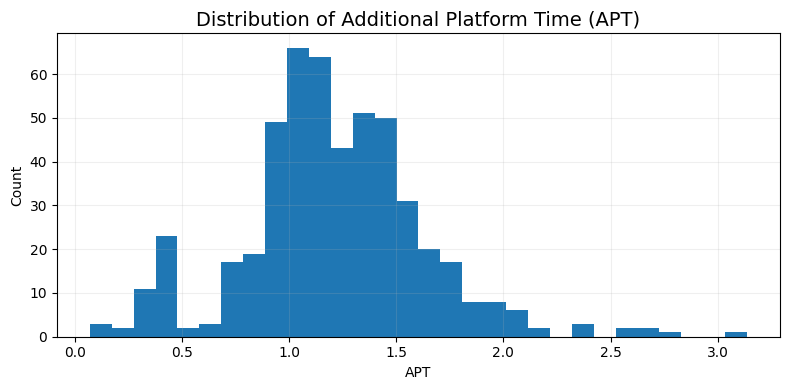

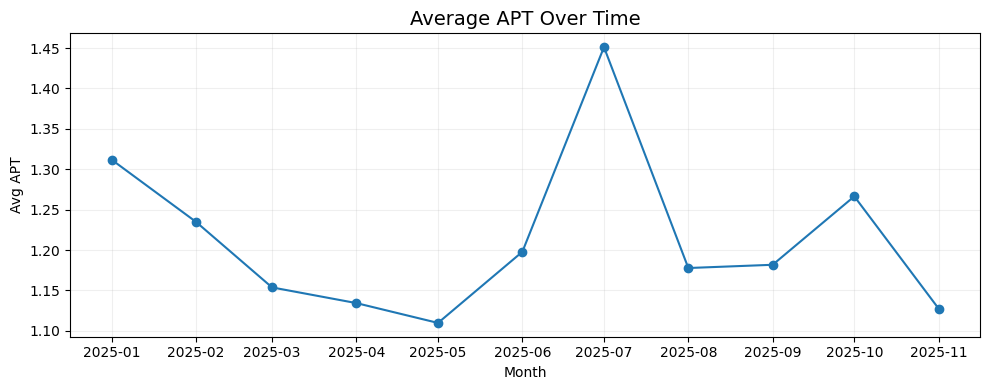

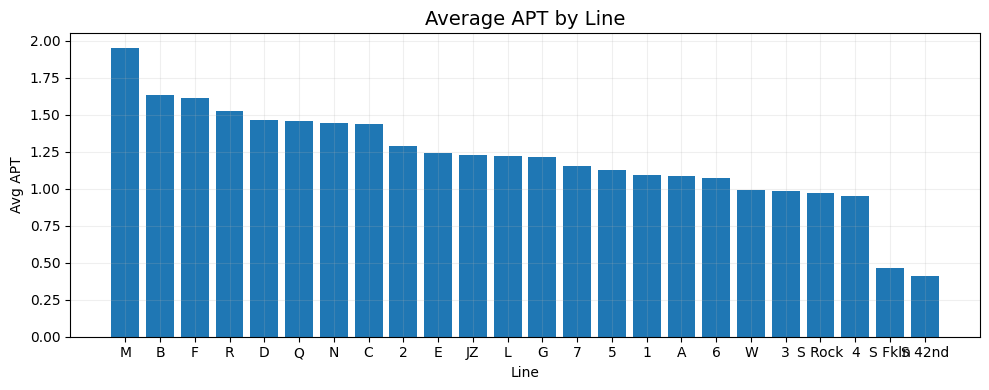

In [ ]:
import matplotlib.pyplot as plt

def nice_plot(title, xlabel=None, ylabel=None):
    plt.title(title, fontsize=14)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

# Distribution
plt.figure(figsize=(8,4))
plt.hist(df_model[TARGET], bins=30)
nice_plot("Distribution of Additional Platform Time (APT)", xlabel="APT", ylabel="Count")
plt.show()

# Trend over time
monthly_mean = df_model.groupby("month")[TARGET].mean().reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly_mean["month"], monthly_mean[TARGET], marker="o")
nice_plot("Average APT Over Time", xlabel="Month", ylabel="Avg APT")
plt.show()

# By line
line_mean = df_model.groupby("line")[TARGET].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.bar(line_mean.index.astype(str), line_mean.values)
nice_plot("Average APT by Line", xlabel="Line", ylabel="Avg APT")
plt.show()


## 10) Train/test split (time-based)

We split by months (not random rows) to avoid leakage.
- First 80% of months = train
- Last 20% of months = test


In [ ]:
# Sort by time
df_model = df_model.sort_values("month").reset_index(drop=True)

months_sorted = df_model["month"].drop_duplicates().sort_values().reset_index(drop=True)
cut = int(len(months_sorted) * 0.8)

train_months = set(months_sorted.iloc[:cut])
test_months = set(months_sorted.iloc[cut:])

train = df_model[df_model["month"].isin(train_months)].copy()
test  = df_model[df_model["month"].isin(test_months)].copy()

print("Train months:", len(train_months), "Test months:", len(test_months))
print("Train rows:", len(train), "Test rows:", len(test))


Train months: 8 Test months: 3
Train rows: 360 Test rows: 144


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Categorical features
categorical = ["line", "day_type", "season"]

div_col = find_col(df_model.columns, [r"division"])
period_col = find_col(df_model.columns, [r"time.*period", r"\bperiod\b"])

# Normalize optional cols into consistent names
if div_col and div_col != "division":
    df_model.rename(columns={div_col: "division"}, inplace=True)
    train.rename(columns={div_col: "division"}, inplace=True)
    test.rename(columns={div_col: "division"}, inplace=True)
    div_col = "division"

if period_col and period_col != "time_period":
    df_model.rename(columns={period_col: "time_period"}, inplace=True)
    train.rename(columns={period_col: "time_period"}, inplace=True)
    test.rename(columns={period_col: "time_period"}, inplace=True)
    period_col = "time_period"

if div_col and div_col in df_model.columns:
    categorical.append(div_col)
if period_col and period_col in df_model.columns:
    categorical.append(period_col)

# Numeric features
base_numeric = [
    "year", "month_num", "quarter", "holiday_count",
    "apt_lag_1", "apt_lag_2", "apt_roll3_mean",
]
incident_lag_features = [c for c in df_model.columns if c.endswith("_lag_1") and c not in ["apt_lag_1"]]

numeric = base_numeric + incident_lag_features
numeric = [c for c in numeric if c in df_model.columns]
categorical = [c for c in categorical if c in df_model.columns]

features = categorical + numeric

X_train = train[features]
y_train = train[TARGET]
X_test  = test[features]
y_test  = test[TARGET]

# Impute missing values
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical),
        ("num", numeric_transformer, numeric)
    ],
    remainder="drop"
)

print("Categorical:", categorical)
print("Numeric count:", len(numeric))
print("Total features:", len(features))

# Quick check to see where NaNs are coming from just in case
nan_counts = X_train.isna().sum().sort_values(ascending=False)
print("\nTop NaN columns (train):")
display(nan_counts.head(10))


Categorical: ['line', 'day_type', 'season', 'division', 'time_period']
Numeric count: 13
Total features: 18

Top NaN columns (train):


,0
apt_lag_2,24
line,0
day_type,0
season,0
time_period,0
division,0
month_num,0
quarter,0
holiday_count,0
year,0


## 11) Models

We compare:
1) Baseline: predict last month's APT (apt_lag_1)
2) Ridge regression (strong + simple)
3) RandomForest (nonlinear, easy to explain)
4) HistGradientBoosting (usually very strong on tabular)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:>18} | MAE: {mae:7.4f} | RMSE: {rmse:7.4f} | R2: {r2:7.4f}")
    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []

# Baseline of last month's APT
baseline_pred = X_test["apt_lag_1"].values
results.append(eval_regression("Baseline (lag1)", y_test.values, baseline_pred))

# Ridge
ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=0))
])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
results.append(eval_regression("Ridge", y_test.values, ridge_pred))

# RandomForest
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=0,
        n_jobs=-1,
        min_samples_leaf=2
    ))
])
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results.append(eval_regression("RandomForest", y_test.values, rf_pred))

# HistGradientBoosting
hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.06,
        max_depth=6,
        random_state=0
    ))
])
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)
results.append(eval_regression("HistGB", y_test.values, hgb_pred))

results_df = pd.DataFrame(results).sort_values("MAE")
results_df


   Baseline (lag1) | MAE:  0.2013 | RMSE:  0.2854 | R2:  0.3129
             Ridge | MAE:  0.2602 | RMSE:  0.3371 | R2:  0.0415
      RandomForest | MAE:  0.1971 | RMSE:  0.2649 | R2:  0.4081
            HistGB | MAE:  0.1931 | RMSE:  0.2627 | R2:  0.4178


,model,MAE,RMSE,R2
3,HistGB,0.193131,0.262690,0.417782
2,RandomForest,0.197058,0.264868,0.408090
0,Baseline (lag1),0.201279,0.285367,0.312922
1,Ridge,0.260231,0.337060,0.041455


## 12) Diagnostics: predicted vs actual + residuals over time

- are errors bigger during spike months?
- does the model systematically under/over-predict?


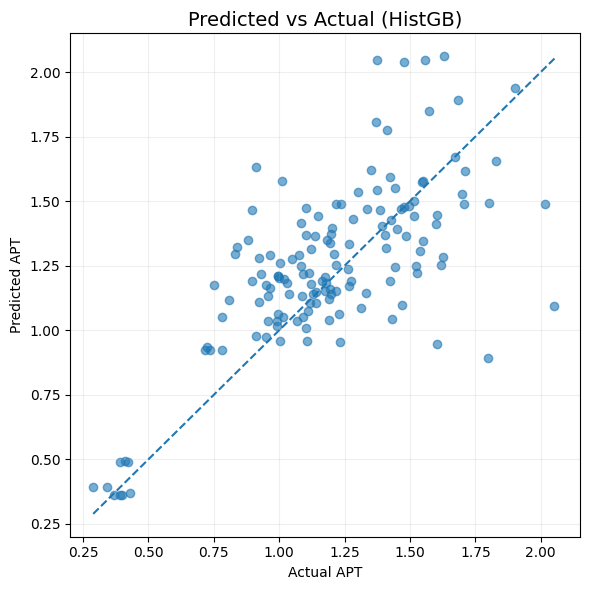

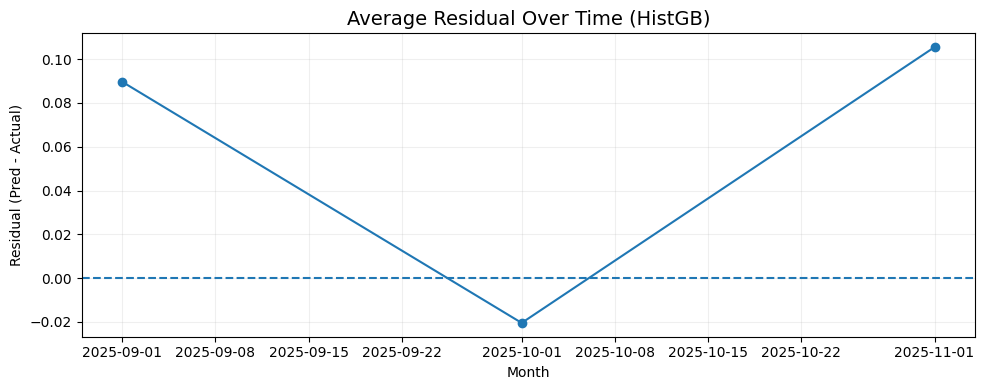

In [ ]:
# Pick best model by MAE
best_name = results_df.iloc[0]["model"]

pred_map = {
    "Baseline (lag1)": baseline_pred,
    "Ridge": ridge_pred,
    "RandomForest": rf_pred,
    "HistGB": hgb_pred
}
best_pred = pred_map[best_name]

# Pred vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
lims = [min(float(y_test.min()), float(np.min(best_pred))), max(float(y_test.max()), float(np.max(best_pred)))]
plt.plot(lims, lims, linestyle="--")
nice_plot(f"Predicted vs Actual ({best_name})", xlabel="Actual APT", ylabel="Predicted APT")
plt.show()

# Residuals over time
resid = best_pred - y_test.values
tmp = test[["month", "line", "day_type"]].copy()
tmp["residual"] = resid

monthly_resid = tmp.groupby("month")["residual"].mean().reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly_resid["month"], monthly_resid["residual"], marker="o")
plt.axhline(0, linestyle="--")
nice_plot(f"Average Residual Over Time ({best_name})", xlabel="Month", ylabel="Residual (Pred - Actual)")
plt.show()


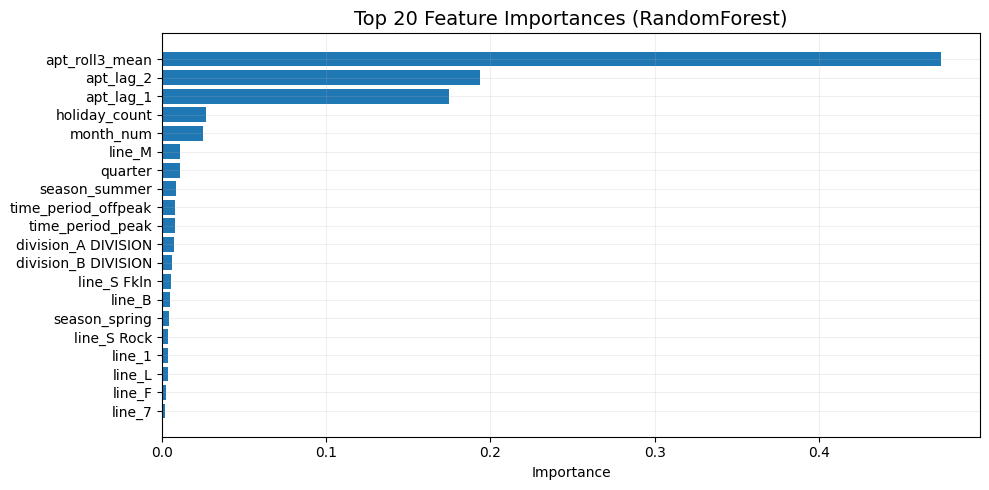

,feature,importance
38,apt_roll3_mean,0.474499
37,apt_lag_2,0.193660
36,apt_lag_1,0.175010
35,holiday_count,0.026745
33,month_num,0.024896
16,line_M,0.011197
34,quarter,0.010864
26,season_summer,0.008190
30,time_period_offpeak,0.007937
31,time_period_peak,0.007898


In [ ]:
# Random forest
ohe = rf.named_steps["prep"].named_transformers_["cat"]

cat_feature_names = []
if len(categorical) > 0:
    cat_feature_names = list(ohe.get_feature_names_out(categorical))

all_feature_names = cat_feature_names + numeric

importances = rf.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": all_feature_names, "importance": importances}).sort_values("importance", ascending=False)

topk = fi.head(20)

plt.figure(figsize=(10,5))
plt.barh(topk["feature"][::-1], topk["importance"][::-1])
nice_plot("Top 20 Feature Importances (RandomForest)", xlabel="Importance")
plt.show()

topk
